<a href="https://colab.research.google.com/github/ZhihaoDC/TFG/blob/main/source/1%20-%20Dibujo%20del%20grafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

# %cd /gdrive/My Drive/TFG
#!git init

In [ ]:
#!git clone https://github.com/ZhihaoDC/TFG.git

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/TFG

!git pull https://github.com/ZhihaoDC/TFG

Mounted at /gdrive
/gdrive/My Drive/TFG
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/ZhihaoDC/TFG
 * branch            HEAD       -> FETCH_HEAD
Updating df80e67..02250e8
Fast-forward
 source/1 - Dibujo del grafo.ipynb | 9831 ++++++++++++++++++-------------------
 1 file changed, 4675 insertions(+), 5156 deletions(-)


# Marvel vs DC dataset

### Import Libraries

In [370]:
#Import libraries
import pandas as pd
import numpy as np
import re #regular expressions
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import statistics
import sklearn.metrics, sklearn.preprocessing, sklearn.feature_extraction.text, sklearn.decomposition

In [371]:
pd.set_option('max_colwidth',None)
pd.set_option("precision",3)

###Read files and peek

In [372]:
#Read files and peek
#We will use the following dictionary to define the types of the data, as it can all be str at the time of reading the .csv file
#my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':np.int64, 'Minutes':np.int64, 'Release':np.int64, 'Budget':np.int64, 'Opening Weekend USA':np.int64, 'Gross USA': np.int64, 'Gross Worldwide':np.int64}

#Edited (Minutes and Budget are columns that can't be converted to int)
# my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':int, 'Release':int, 'Opening Weekend USA':int, 'Gross USA': int, 'Gross Worldwide':int}

marvel_dc = pd.read_csv("./datasets/marvel-vs-dc/db.csv",  encoding='ISO-8859-1')

marvel_dc.head()

,Unnamed: 0,Original Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening Weekend USA,Gross USA,Gross Worldwide
0,1,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,2,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,3,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,4,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,5,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


### Data cleaning

In [373]:
#Check read
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                 object
Release                  int64
Budget                  object
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

In [374]:
#Convert column dtypes to more suitable dtypes
marvel_dc['Original Title'] = marvel_dc['Original Title'].astype(str)
marvel_dc['Company'] = marvel_dc['Company'].astype(str)
marvel_dc['Minutes'] = marvel_dc['Minutes'].astype(np.int64)
marvel_dc['Budget'] = marvel_dc['Budget'].astype(np.int64)
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                  int64
Release                  int64
Budget                   int64
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

We can see that 'Original Title' and 'Company' have remained as 'object' types, instead of 'str'.

This may hint at some characters that have not been decoded properly

In [375]:
print(marvel_dc['Original Title'])

0                                Iron Man
1                     The Incredible Hulk
2                              Iron Man 2
3                                    Thor
4      Captain America: The First Avenger
5                            The Avengers
6                          Iron Man Three
7                    Thor: The Dark World
8     Captain America: The Winter Soldier
9                 Guardians of the Galaxy
10               Avengers: Age of Ultron 
11                                Ant-Man
12             Captain America: Civil War
13                         Doctor Strange
14         Guardians of the Galaxy Vol. 2
15                 Spider-Man: Homecoming
16                          Thor:Ragnarok
17                          Black Panther
18                 Avengers: Infinity War
19                   Ant-Man and the Wasp
20                          Captain Marve
21                      Avengers: Endgame
22              Spider-Man: Far from Home
23                               C

We can see some blank spaces trailing in movie titles like "Suicide Squad ", "Avengers: Age of Ultron ", "Jonah Hex " 

In [376]:
marvel_dc['Original Title'] = marvel_dc['Original Title'].str.strip()
marvel_dc['Original Title'] = marvel_dc['Original Title'].str.replace("  "," ") #Check for double spaces
marvel_dc[marvel_dc['Original Title'] == 'Suicide Squad']

,Unnamed: 0,Original Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening Weekend USA,Gross USA,Gross Worldwide
33,34,Suicide Squad,DC,6.0,40,123,2016,175000000,133682248,325100054,746846894


We can do the same for the column 'Company'

In [377]:
marvel_dc['Company'] = marvel_dc['Company'].str.strip()

We can also replace the spaces in the variable names

In [378]:
new_columns = [column.replace(" ", "_") for column in marvel_dc.columns]
print(new_columns)

#Out: ['Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']
#Look at'Gross\xa0USA'
#This will result in an error if we tried to execute marvel_dc['Gross USA']

['Unnamed:_0', 'Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']


As we can see, we have an unknown character '\xa0' disguised as an space

In [379]:
marvel_dc.columns = marvel_dc.columns.str.normalize('NFKC')
print(marvel_dc.columns)
#Now we can execute 
#marvel_dc['Gross USA']

Index(['Unnamed: 0', 'Original Title', 'Company', 'Rate', 'Metascore',
       'Minutes', 'Release', 'Budget', 'Opening Weekend USA', 'Gross USA',
       'Gross Worldwide'],
      dtype='object')


In [380]:
#Replace spaces in column names
marvel_dc.columns = [column.replace(" ", "_") for column in marvel_dc.columns]
print(marvel_dc.columns)

Index(['Unnamed:_0', 'Original_Title', 'Company', 'Rate', 'Metascore',
       'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross_USA',
       'Gross_Worldwide'],
      dtype='object')


In [381]:
marvel_dc['Original_Title'] = marvel_dc['Original_Title'].astype(str)
marvel_dc['Company'] = marvel_dc['Company'].astype(str)

In [382]:
#Search for null values
null_values=pd.DataFrame(data=marvel_dc.isnull().any(), columns={'has_null_values'})
null_values

,has_null_values
Unnamed:_0,False
Original_Title,False
Company,False
Rate,False
Metascore,False
Minutes,False
Release,False
Budget,False
Opening_Weekend_USA,False
Gross_USA,False


In [383]:
#Drop non useful columns
marvel_dc = marvel_dc.drop(columns= 'Unnamed:_0')
marvel_dc.head()

,Original_Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide
0,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


###Variable preview

We can see some of the correlations between variables with corr() function from pandas, which gives us a correlation matrix using Pearson correlation coefficient (which differs from covariance in the sense that Pearson's correlation doesn't vary depending on the magnitude or scaleof the data.

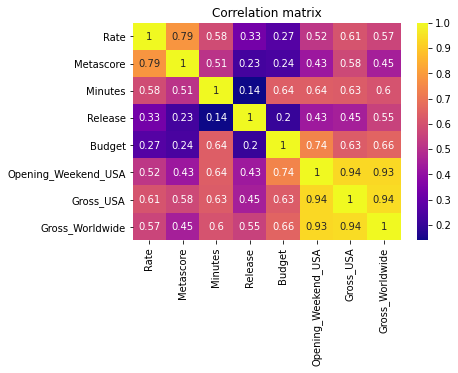

In [384]:
corr_matrix= marvel_dc.drop(columns=['Original_Title']).corr()
sb.heatmap(corr_matrix, annot=True, cmap='plasma')
plt.title('Correlation matrix')
plt.show()

We can see that those variables related to reputation of the film as 'score' or 'metascore' are highly correlated.

However a more noteworthy observation is the high correlation between those variables that imply profits made from the film('Opening_Weekend_USA', 'Gross_USA', 'Gross_Worldwide'), since one is a subset of the other, which is also a subset of the other. 'Budget' also seems to be correlated with these variables.

Also, the variables that imply profit are somewhat correlated with the rest, since a good film (high 'Rate' )is generally likely to have good earnings and budget.

We can guess that two powerful variables can be Metascore and Gross_Worldwide

We might want to carry out a statistical significance study if we want to fully rely on this correlation matrix

In [385]:
px.scatter_matrix(marvel_dc.drop(columns=['Original_Title','Company']),width=1800, height=1600)

We can see again that 'Opening_Weekend_USA' , 'Gross_USA' , 'Gross_Worldwide' (and even 'Budget') are positively and highly correlated. We might want to use one of these instead of all three (or four).

'Rate' and 'Metascore' are also highly correlated

Both previous groups seem to be somewhat correlated (with the exception of 'Budget').




Budget has an average budget of 184.10 million dollars


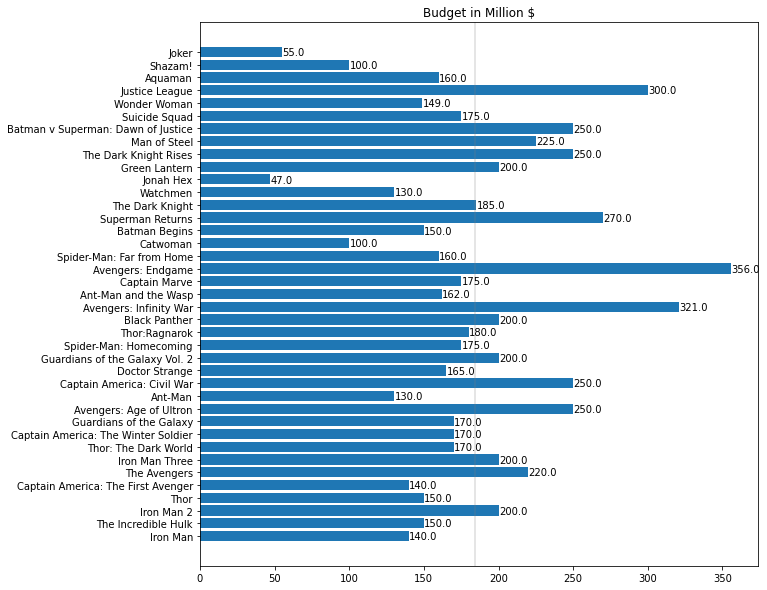

In [386]:
#Plot budget in million $
budget_millions = marvel_dc['Budget']/1000000

AVG_BUDGET = statistics.mean(budget_millions)
print('Budget has an average budget of', format(AVG_BUDGET,'.2f') , 'million dollars' )

plt.figure(figsize=(10,10))
ax= plt.subplot(111)

ax.barh(y=marvel_dc['Original_Title'], width=budget_millions)

for count, value in enumerate(budget_millions):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(x=AVG_BUDGET, color='grey', linewidth=0.4)
    
plt.title('Budget in Million $')
plt.show()

The average rating for a marvel/dc movie is 7.202564102564103


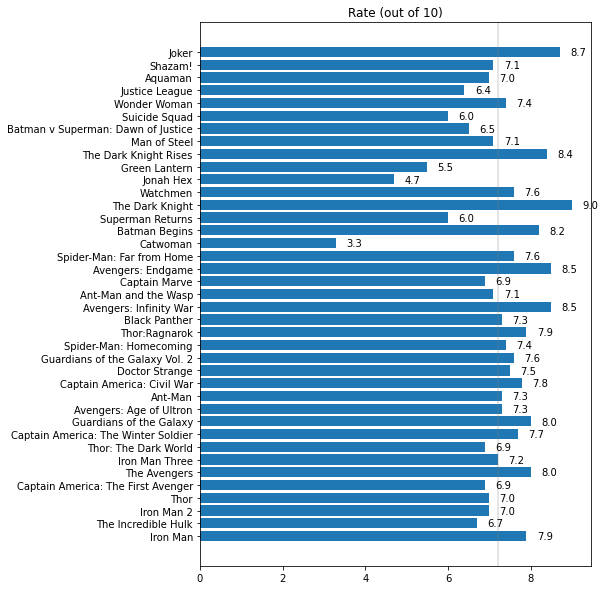

In [387]:
#Plot Rate
AVG_RATE = statistics.mean(marvel_dc['Rate'])
print("The average rating for a marvel/dc movie is",AVG_RATE)

plt.figure(figsize=(7,10))
ax= plt.subplot(111)
ax.barh(y=marvel_dc['Original_Title'], width=marvel_dc['Rate'], )

for count, value in enumerate(marvel_dc['Rate']):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(AVG_RATE, color='grey', linewidth=0.4)
    
plt.title('Rate (out of 10)')
plt.show()

The average earnings for a marvel/dc movie is 827.5726761538461


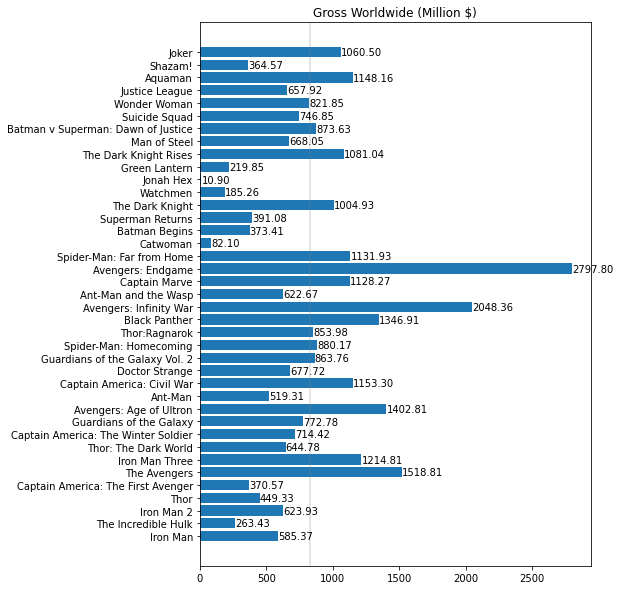

In [388]:
#Plot Gross_Worldwide
gross_wrld_millions = marvel_dc['Gross_Worldwide'] / 1000000
AVG_GROSS_WRLD = statistics.mean(gross_wrld_millions)
print("The average earnings for a marvel/dc movie is",AVG_GROSS_WRLD)

plt.figure(figsize=(7,10))
ax= plt.subplot(111)

ax.barh(y=marvel_dc['Original_Title'], width=gross_wrld_millions, )

for count, value in enumerate(gross_wrld_millions):
    ax.text(x= value+0.25, y= count-0.25, s= format(value,'.2f'))

ax.axvline(AVG_GROSS_WRLD, color='grey', linewidth=0.4)
    
plt.title('Gross Worldwide (Million $)')
plt.show()

### Data preparation

####Encoding

Now, we need a similarity measure, but in order to use all the variables possible, we need to encode them.



In [389]:
def encode_company(companies):
  encoded_companies = []

  for company in companies:
    if company == 'Marvel':
      encoded_companies.append(0)
    elif company == 'DC':
      encoded_companies.append(1)
    else:
      encoded_companies.append(np.nan)
      
  return encoded_companies

In [390]:
#Create a copy of the dataset and add encoded columns
marvel_dc_copy = marvel_dc.copy()
marvel_dc_copy['0:_Marvel_1:_DC'] = encode_company(marvel_dc['Company'])

In [391]:
#Drop no encoded columns
marvel_dc_nostr = marvel_dc_copy.drop(columns=['Original_Title','Company'])
plt.show()

####Bag of words

We don't want to lose the relationship that some movie titles. We can apply a process commonly known as 'Bag of Words' in which we count the number of occurences of all the words. This results in a vector that is called a 'vocabulary'.

Using a vocabulary enables us to link prequels to sequels, since many of them share certain keywords like 'Iron Man' in 'Iron Man', 'Iron Man 2', etc.

(We can also ignore some irrelevant words that convey no meaning at all, like words like 'the', punctuation notes, etc.)


To carry out this little analysis, we will be depending on sklearn's CountVectorizer, which gives us the exact same funtionality as mentioned above

In [392]:
# mystop_words =['the','of','man','and','volume','vol','part','pt','1','2','3','4','5','one','two','three','four','five']
# vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=2)
# vectorizer.fit(marvel_dc['Original_Title'])
# vocabulary_values = vectorizer.transform(marvel_dc['Original_Title']).toarray()
# vocabulary = vectorizer.get_feature_names()

# print(vocabulary)

In [393]:
def get_hero_name (movie_title):
  """Get hero name from movie title, removing spaces or dashes in cases like 'Iron Man' or 'Ant-Man' """

  hero_name = movie_title.split(':')[0] #Get hero name

  hero_name = re.sub(r'.Man','Man',hero_name) #Clean hero name from spaces or dash
  #'.Man' <-- regexp corresponds to one character followed by 'Man'

  return hero_name

In [394]:
marvel_dc.loc[marvel_dc['Original_Title']=='Captain Marve']

,Original_Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide
20,Captain Marve,Marvel,6.9,64,123,2019,175000000,153433423,426829839,1128274794


In [395]:
hero_names = marvel_dc['Original_Title'].apply(lambda x: get_hero_name(x))
print(hero_names)

0                            IronMan
1                The Incredible Hulk
2                          IronMan 2
3                               Thor
4                    Captain America
5                       The Avengers
6                      IronMan Three
7                               Thor
8                    Captain America
9            Guardians of the Galaxy
10                          Avengers
11                            AntMan
12                   Captain America
13                    Doctor Strange
14    Guardians of the Galaxy Vol. 2
15                         SpiderMan
16                              Thor
17                     Black Panther
18                          Avengers
19               AntMan and the Wasp
20                     Captain Marve
21                          Avengers
22                         SpiderMan
23                          Catwoman
24                     Batman Begins
25                  Superman Returns
26                   The Dark Knight
2

In [396]:
mystop_words =['the','of','man','and','volume','vol','part','pt','1','2','3','4','5','one','two','three','four','five']
#We might want to use only those features that connect two diferent movies --> min_df=2
vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=2, stop_words=mystop_words) 
vectorizer.fit(hero_names)
vocabulary_values = vectorizer.transform(hero_names).toarray()
vocabulary = vectorizer.get_feature_names()

print(vocabulary)

['america', 'antman', 'avengers', 'batman', 'captain', 'dark', 'galaxy', 'guardians', 'ironman', 'knight', 'spiderman', 'superman', 'thor']


In [397]:
bagOfWords = pd.DataFrame(data=vocabulary_values, columns=vocabulary)
bagOfWords.head(10)
#len(values.columns) #13

,america,antman,avengers,batman,captain,dark,galaxy,guardians,ironman,knight,spiderman,superman,thor
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,1,0,0,0,0,0


In [398]:
#Idea
# titles_sequel = marvel_dc['Original_Title'].str.find(':')
# bool_find = titles_sequel > 0

In [399]:
marvel_dc_nostr_bow=pd.concat([marvel_dc_nostr, bagOfWords], axis=1)
marvel_dc_nostr_bow.head()

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC,america,antman,avengers,batman,captain,dark,galaxy,guardians,ironman,knight,spiderman,superman,thor
0,7.9,79,126,2008,140000000,98618668,318604126,585366247,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6.7,61,112,2008,150000000,55414050,134806913,263427551,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.0,57,124,2010,200000000,128122480,312433331,623933331,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7.0,57,115,2011,150000000,65723338,181030624,449326618,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6.9,66,124,2011,140000000,65058524,176654505,370569774,0,1,0,0,0,1,0,0,0,0,0,0,0,0


####Standarize data

In order to find a proper similarity measure, we need to normalize the data, since variables with larger-order of magnitudes might dominate (or have too much of an influence) our similarity measure

We will be using sklearn.preprocessing.StandardScaler() for this process, which uses a standard score of a sample x, calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [400]:
#Scale data with sklearn
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(marvel_dc_nostr)

#print means
means = ['{0:0.2f}'.format(mean) for mean in scaler.mean_]
print(means)

#print variances
variances = ['{0:0.2f}'.format(var) for var in scaler.var_]
print(variances)

#transform the dataset into scaled dataset
marvel_dc_transformed = scaler.transform(marvel_dc_nostr) 

#display scaled dataset
marvel_dc_scaled = pd.DataFrame(data=marvel_dc_transformed, columns=marvel_dc_nostr.columns, index=marvel_dc['Original_Title'])
display(marvel_dc_scaled)
#print(df_scaled.loc['Avengers: Endgame'])

['7.20', '63.67', '131.85', '2013.79', '184102564.10', '115109770.31', '323265922.87', '827572676.15', '0.41']
['1.13', '187.20', '331.41', '17.91', '4042297172912558.00', '4594265917994789.00', '31818266288807104.00', '277045486308681056.00', '0.24']


,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
Iron Man,0.657,1.121,-0.321,-1.369,-0.694,-0.243,-0.026,-0.460,-0.834
The Incredible Hulk,-0.474,-0.195,-1.090,-1.369,-0.536,-0.881,-1.057,-1.072,-0.834
Iron Man 2,-0.191,-0.487,-0.431,-0.897,0.250,0.192,-0.061,-0.387,-0.834
Thor,-0.191,-0.487,-0.925,-0.660,-0.536,-0.729,-0.797,-0.719,-0.834
Captain America: The First Avenger,-0.285,0.171,-0.431,-0.660,-0.694,-0.738,-0.822,-0.868,-0.834
The Avengers,0.752,0.390,0.613,-0.424,0.565,1.362,1.682,1.313,-0.834
Iron Man Three,-0.002,-0.122,-0.101,-0.188,0.250,0.871,0.481,0.736,-0.834
Thor: The Dark World,-0.285,-0.707,-1.090,-0.188,-0.222,-0.433,-0.655,-0.347,-0.834
Captain America: The Winter Soldier,0.469,0.463,0.228,0.048,-0.222,-0.296,-0.356,-0.215,-0.834


A little interpretation of what we have in the prior figure is that, taken a row such as 'Avengers: Endgame':

    Rate                   1.223029
    Metascore              1.047607
    Minutes                2.700059
    Release                1.230055
    Budget                 2.703680
    Opening_Weekend_USA    3.570399
    Gross_USA              2.999870
    Gross_Worldwide        3.743182
    0:_Marvel_1:_DC       -0.834058
    Name: Avengers: Endgame, dtype: float64

We can see that Rate is 1.223029 which means that this observation has a rate that is 1.223029 standard deviations away from the average rate

Rate has a variance of ~1.13

Which would mean that Avengers: Endgame has 1.223029 · 1.13 = 1,38202277~ above the average (7.20) which means that 1,38202277 + 7.20 = 8,58202277~ is the rate of 'Avengers: Endgame'.

The same goes for Catwoman which has a rate of -3.678755 · 1.13 = 

Although we have pretty reasonable results, we have observed that the great variability on the data (such as the one in columns 'Budget' or 'Minutes') causes still some notable variability in the standarized data. This variability can make some columns to 'dominate' with its influence on the similarity measure.

We can tackle this by standarizing the data in a way that it ranges from 0 to 1.

In [401]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(marvel_dc_nostr_bow)

marvel_dc_std = scaler.transform(marvel_dc_nostr_bow)

marvel_dc_std = pd.DataFrame(data=marvel_dc_std, index=marvel_dc['Original_Title'], columns=marvel_dc_nostr_bow.columns)
marvel_dc_std

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC,america,antman,avengers,batman,captain,dark,galaxy,guardians,ironman,knight,spiderman,superman,thor
Original_Title,,,,,,,,,,,,,,,,,,,,,,
Iron Man,0.807,0.852,0.45,0.267,0.301,0.265,0.363,0.206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
The Incredible Hulk,0.596,0.557,0.31,0.267,0.333,0.142,0.147,0.091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iron Man 2,0.649,0.492,0.43,0.400,0.495,0.349,0.356,0.220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Thor,0.649,0.492,0.34,0.467,0.333,0.172,0.201,0.157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Captain America: The First Avenger,0.632,0.639,0.43,0.467,0.301,0.170,0.196,0.129,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Avengers,0.825,0.689,0.62,0.533,0.560,0.574,0.723,0.541,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iron Man Three,0.684,0.574,0.49,0.600,0.495,0.480,0.470,0.432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Thor: The Dark World,0.632,0.443,0.31,0.600,0.398,0.228,0.231,0.227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Captain America: The Winter Soldier,0.772,0.705,0.55,0.667,0.398,0.255,0.294,0.252,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####Dimensionality Reduction (PCA)

We have noticed in some iterations that our similarity measure like the cosine similarity does not behave as expected. Therefore, we aim to reduce the number of variables in order to filter the 'noise' that some variables introduce to our metric.

A recently popular way of doing this is the Principal Component Analysis or 'PCA'


*Data with a large number of features, such as more features (columns) than observations (rows) may be reduced to a smaller subset of features that are most relevant to the prediction problem.*

*PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.*

Reference: [PCA on machinelearningmastery.com](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/)

[Eigendecomposition used in PCA](https://machinelearningmastery.com/introduction-to-eigendecomposition-eigenvalues-and-eigenvectors/)

The idea behind PCA is that, by using eigendecomposition, we can find a reasonable projection for our dataset into a lower dimensional one (less variables).


First, using the covariance matrix of the mean column value for our dataset, we can eigendecompose it to get a reduced subspace where the eigenvectors indicate its direction and the eigenvalues indicate its magnitude. (Eigenvectors and eigenvalues are a form of 'decomposing' a matrix, since an operation between them results in the original matrix)

Then, we can sort our eigenvectors by the magnitude of their eigenvalues, and watch the difference between them. If differences are minimal, we can say that the matrix is already pretty dense and that the projection of our dataset into a lower dimensional one will not offer much. On the contrary, if we see that some eigenvectors have their corresponding eigenvalues close to 0, then we may discard the columns corresponding to that eigenvector.

We can then choose the k eigenvectors that have the highest eigenvalue as the main components for our new matrix.

Our approach will not be using the eigendecomposition method for PCA, since it is only applicable for square matrices. We will be using the Singular Value Decomposition or 'SVD' for short.

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.


A = U . Sigma . V^T


Where A is the real m x n matrix that we wish to decompose, U is an m x m matrix, Sigma (often represented by the uppercase Greek letter Sigma) is an m x n diagonal matrix, and V^T is the  transpose of an n x n matrix where T is a superscript.

Reference: [SVD on machinelearningmastery.com](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/)

This is implemented in the library scikit-learn.
 In scikit-learn, PCA is implemented as a transformer object that learns  components in its fit method, and can be used on new data to project it on these components.

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

In [402]:
pca = sklearn.decomposition.PCA(whiten=True)
pca.fit(marvel_dc_std)
marvel_dc_pca = pca.transform(marvel_dc_std) #dataset with dimensionality reduction
pca.components_ #They are sorted by explained_variance_ (importance)

df_pca_cols = ['PC'+str(num) for num,value in enumerate(pca.components_)]

marvel_dc_pca = pd.DataFrame(data= marvel_dc_pca, index= marvel_dc_std.index ,columns=df_pca_cols)

display(marvel_dc_pca)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
Original_Title,,,,,,,,,,,,,,,,,,,,,,
Iron Man,0.407,-0.684,-0.699,1.227,-2.112,1.436,-1.387,0.480,-0.685,-0.631,0.859,0.844,0.300,-0.544,0.275,-0.206,-1.026,-0.116,-0.263,-0.031,-0.684,-0.880
The Incredible Hulk,-0.033,-0.993,-0.515,0.307,-0.703,0.300,0.186,-0.405,0.817,1.152,0.166,0.210,1.285,1.490,-1.400,-0.910,2.479,-0.550,0.303,0.651,1.089,-0.880
Iron Man 2,0.357,-0.660,-0.800,0.621,-2.000,1.482,-1.346,0.173,-0.960,-0.837,-0.624,-0.523,-0.704,-0.229,0.025,-0.547,0.242,0.056,-0.695,-1.259,-1.360,2.829
Thor,0.167,-1.161,-1.010,0.267,-0.918,-1.075,2.679,0.094,-0.524,-0.151,0.033,0.011,-0.302,-0.237,0.467,0.188,0.098,-0.240,0.008,-0.617,-5.114,2.872
Captain America: The First Avenger,0.567,-1.824,2.656,-0.123,-0.152,0.457,0.288,-0.509,0.304,0.562,0.276,0.125,-0.224,-0.911,-0.629,0.218,-0.226,0.354,-0.087,-0.668,-0.262,-1.498
The Avengers,1.227,1.140,-0.403,-0.864,-0.817,0.534,0.431,-1.343,0.865,1.054,0.955,0.179,0.727,-1.005,0.358,0.371,-0.230,-0.638,-1.166,-2.079,1.426,-3.353
Iron Man Three,0.641,-0.273,-0.729,0.514,-1.712,1.219,-1.550,0.418,-1.318,-1.343,-0.614,-0.638,-0.497,-0.369,0.076,0.534,0.234,0.251,0.973,1.258,-2.710,4.684
Thor: The Dark World,0.262,-1.041,-1.025,0.070,-0.746,-1.207,2.593,0.115,-0.729,-0.426,-0.356,-0.409,-0.416,-0.231,0.126,0.174,-0.033,-0.451,0.386,0.101,-5.790,4.108
Captain America: The Winter Soldier,0.850,-1.399,2.770,-0.173,0.135,0.240,0.157,-0.147,-0.003,0.041,0.331,0.269,-0.631,-0.822,-0.532,0.016,0.330,-0.075,0.505,-0.688,-0.262,0.356


In [403]:
pca_components = pd.DataFrame(data=pca.components_, index=df_pca_cols, columns=marvel_dc_std.columns)
display(pca_components.transpose())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
Rate,0.166,0.168,0.066,0.218,3.594e-02,-0.073,0.001,0.151,-0.013,-0.107,0.422,0.106,-0.154,-0.184,0.060,-0.321,0.276,-0.635,-0.131,-0.005,9.300e-18,6.368e-19
Metascore,0.219,0.127,0.104,0.313,2.202e-02,-0.058,-0.041,0.244,0.083,-0.004,0.297,0.489,0.245,0.173,-0.131,-0.009,-0.477,0.225,0.005,0.205,3.340e-18,-6.671e-17
Minutes,0.068,0.291,0.154,0.027,-5.104e-04,0.086,0.049,0.165,-0.010,-0.009,0.061,0.286,-0.297,0.052,0.378,0.033,0.478,0.505,0.094,-0.189,9.228e-17,5.114e-17
Release,0.222,0.108,-0.027,-0.229,4.593e-01,-0.405,-0.227,0.161,-0.222,-0.366,-0.115,-0.130,0.043,-0.226,-0.190,-0.251,-0.026,0.239,-0.009,-0.100,6.176e-17,6.750e-17
Budget,0.142,0.263,0.061,-0.112,-4.424e-02,0.164,0.139,0.074,0.004,-0.029,-0.425,0.038,-0.404,0.487,-0.164,-0.381,-0.225,-0.173,0.040,-0.049,-3.623e-17,-2.222e-17
Opening_Weekend_USA,0.215,0.270,0.041,-0.059,-3.571e-02,0.066,0.012,-0.011,-0.098,-0.106,-0.101,-0.174,-0.001,0.081,0.024,0.276,0.148,0.048,-0.611,0.573,-3.350e-17,9.786e-17
Gross_USA,0.229,0.309,0.034,0.012,3.618e-03,0.013,-0.046,0.010,-0.115,-0.058,0.002,-0.078,0.176,0.139,0.035,0.520,-0.150,-0.225,-0.133,-0.643,1.123e-16,-6.317e-17
Gross_Worldwide,0.216,0.264,0.018,-0.089,1.441e-02,-0.028,-0.032,-0.015,-0.096,-0.062,-0.024,-0.104,0.010,-0.037,0.102,0.294,0.015,-0.204,0.745,0.392,-2.596e-16,1.523e-17
0:_Marvel_1:_DC,-0.742,0.378,0.179,-0.110,1.616e-01,-0.041,-0.068,-0.091,-0.164,-0.150,0.104,0.125,-0.152,-0.074,0.124,0.074,-0.284,-0.082,-0.062,0.074,-4.648e-17,-1.763e-17
america,0.114,-0.225,0.563,-0.048,2.111e-02,0.083,0.057,-0.051,-0.005,0.020,0.047,0.101,-0.422,-0.284,-0.494,0.295,-0.017,0.017,0.007,-0.023,1.809e-17,7.442e-17


In [404]:
pca.singular_values_
s_values = pd.DataFrame(pca.singular_values_, index=df_pca_cols, columns=['Singular value'])
s_values.head(10)

,Singular value
PC0,3.738
PC1,2.896
PC2,2.403
PC3,2.099
PC4,2.004
PC5,1.859
PC6,1.693
PC7,1.612
PC8,1.463
PC9,1.358


In [405]:
# indexes = pca_components["PC0"].index.values
# fig = ff.create_quiver(x=np.full(len(pca_components),0), 
#                        y=np.full(len(pca_components),0),
#                        u=pca_components['PC0'],
#                        v=pca_components['PC1'], 
#                        scale=1,
#                        arrow_scale=0.05,
#                        hoverinfo='text',
#                        hovertext=indexes)
# # fig.update_traces(
# #     s=pca_components["PC0"].index.values,
# #     hovertemplate='%{s}'
# # )
# fig.update_layout(height=600, width=600)
# fig.show()

In [406]:
def biplot(xs,ys,columns,coeff,labels=None):
    n=len(columns)
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    arrows =[]
    # colors = list(dict.keys(mcolors.CSS4_COLORS))
    colors= [plt.cm.tab20(i) for i in np.linspace(0, 0.9, n)]
    for i in np.arange(n-1):
        arrows.append(plt.arrow(0, 0, coeff[i,0], coeff[i,1],color=colors[i%len(colors)],alpha=0.7,width=0.01))
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color=colors[i%len(colors)], ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color=colors[i%len(colors)], ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(0))
    plt.ylabel("PC{}".format(1))
    plt.grid()
    return arrows

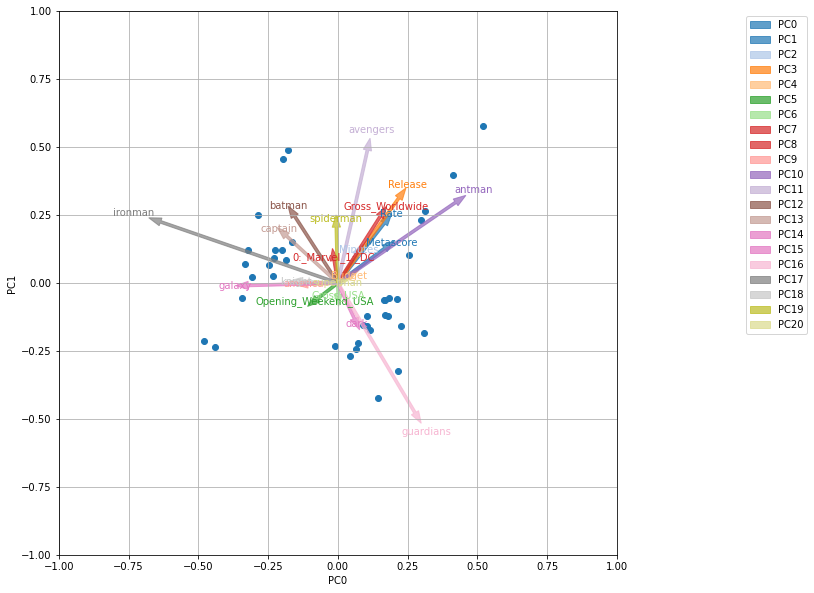

In [407]:
plt.figure(figsize=(10,10))
arrows = biplot(marvel_dc_pca['PC0'],marvel_dc_pca['PC1'],marvel_dc_pca.columns,pca.components_,labels=marvel_dc_std.columns)
plt.legend(arrows, pca_components.index,bbox_to_anchor=(1.35, 1))
plt.show()

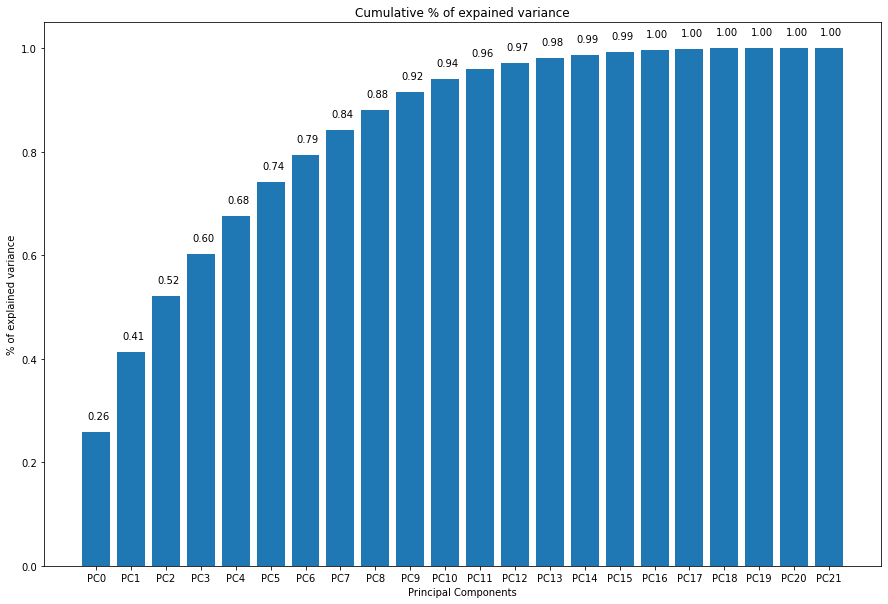

In [408]:
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,10))
ax = plt.subplot(111)
# ax.bar(x=df_pca_cols, height=pca.explained_variance_ratio_)
ax.bar(x=df_pca_cols, height=cumulative)

for count, value in enumerate(cumulative):
  ax.text(x=count-0.25, y=value+0.025, s=format(value,'.2f'))

ax.set_xlabel('Principal Components')
ax.set_ylabel('% of explained variance')
ax.set_title('Cumulative % of expained variance')
plt.show()

Here, we can see that with three principal components (PC0, PC1, PC2) we can explain up to 87% of the variability in our data.

Thus, we may be able to represent up to the 87% of the variability of our dataset with 3 variables PC0, PC1, PC2 which are orthogonal to each other

We will be using PC0 and PC1 since visualizing things in 2D are easier

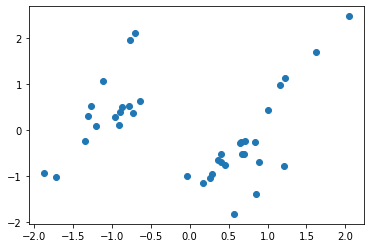

In [409]:
plt.scatter(marvel_dc_pca['PC0'], marvel_dc_pca['PC1'])
plt.show()

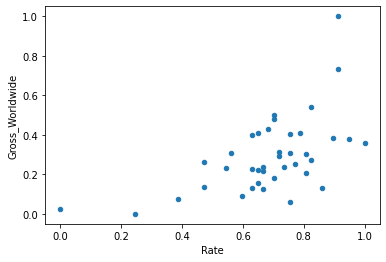

In [410]:
marvel_dc_std[['Rate','Gross_Worldwide']].plot(x='Rate', y='Gross_Worldwide', kind='scatter')

In [411]:
fig=px.scatter_3d(marvel_dc_pca, x='PC0', y='PC1', z='PC2',hover_name=marvel_dc_pca.index)
# Commented for efficiency
fig.show()

As we can see, many similar films are grouped together

### Cosine similarity

We can now use a similarity measure like the cosin similarity, which computes similarity as the normalized dot product of X and Y:

K(X, Y) = <X,Y> / (||X||*||Y||)

In [412]:
movie_1 = marvel_dc_scaled.loc[marvel_dc_scaled.index == 'The Dark Knight Rises']
movie_2 = marvel_dc_scaled.loc[marvel_dc_scaled.index == 'Catwoman']
example = pd.concat([movie_1,movie_2])
display(example)

similarity = sklearn.metrics.pairwise.cosine_similarity(movie_1, movie_2)
movie_titles = [title for title in example.index]
print(movie_titles, similarity, sep=' ')

### Output examples
#['The Dark Knight Rises', 'Catwoman'] [[-0.60190217]] 
#['Avengers: Infinity War', 'Catwoman'] [[-0.76370355]]
#['Avengers: Infinity War', 'Avengers: Endgame'] [[0.97139774]]
#['Avengers: Infinity War', 'Justice League'] [[-0.05384619]]
#['The Avengers', 'Justice League'] [[-0.40653774]]
#['Avengers: Infinity War', 'Suicide Squad'] [[-0.24579913]]

,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide,0:_Marvel_1:_DC
Original_Title,,,,,,,,,
The Dark Knight Rises,1.129,1.048,1.766,-0.424,1.036,0.675,0.700,0.482,1.199
Catwoman,-3.679,-2.680,-1.530,-2.315,-1.323,-1.451,-1.587,-1.416,1.199


['The Dark Knight Rises', 'Catwoman'] [[-0.60190217]]


In [413]:
similarity = sklearn.metrics.pairwise.cosine_similarity(marvel_dc_scaled)
similarity_matrix = pd.DataFrame(similarity, index=marvel_dc_std.index, columns=marvel_dc_std.index)

similarity_matrix.style.background_gradient(cmap='plasma')

Original_Title,Iron Man,The Incredible Hulk,Iron Man 2,Thor,Captain America: The First Avenger,The Avengers,Iron Man Three,Thor: The Dark World,Captain America: The Winter Soldier,Guardians of the Galaxy,Avengers: Age of Ultron,Ant-Man,Captain America: Civil War,Doctor Strange,Guardians of the Galaxy Vol. 2,Spider-Man: Homecoming,Thor:Ragnarok,Black Panther,Avengers: Infinity War,Ant-Man and the Wasp,Captain Marve,Avengers: Endgame,Spider-Man: Far from Home,Catwoman,Batman Begins,Superman Returns,The Dark Knight,Watchmen,Jonah Hex,Green Lantern,The Dark Knight Rises,Man of Steel,Batman v Superman: Dawn of Justice,Suicide Squad,Wonder Woman,Justice League,Aquaman,Shazam!,Joker
Original_Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Man,1.000,0.571,0.401,0.457,0.634,0.096,0.032,0.185,0.621,0.715,-0.218,0.391,-0.045,0.417,-0.071,0.187,0.281,0.045,-0.273,0.145,-0.308,-0.263,-0.046,-0.057,0.555,0.097,0.383,0.142,-0.022,-0.284,-0.028,-0.534,-0.844,-0.727,-0.149,-0.733,-0.696,-0.093,-0.098
The Incredible Hulk,0.571,1.000,0.683,0.957,0.935,-0.564,-0.267,0.810,0.318,0.273,-0.623,0.716,-0.630,0.462,-0.483,-0.206,-0.185,-0.611,-0.771,0.370,-0.388,-0.819,-0.326,0.673,0.430,0.249,-0.392,0.286,0.697,0.550,-0.662,-0.240,-0.506,-0.047,-0.559,-0.063,-0.487,0.105,-0.224
Iron Man 2,0.401,0.683,1.000,0.658,0.517,0.062,0.388,0.656,0.127,0.104,0.038,0.225,-0.138,0.102,-0.082,-0.226,-0.197,-0.258,-0.151,-0.031,-0.121,-0.234,-0.375,0.411,0.069,0.112,-0.272,-0.070,0.280,0.308,-0.428,-0.191,-0.185,-0.033,-0.898,-0.008,-0.744,-0.596,-0.583
Thor,0.457,0.957,0.658,1.000,0.910,-0.578,-0.224,0.921,0.362,0.304,-0.603,0.831,-0.637,0.557,-0.357,-0.107,-0.080,-0.619,-0.733,0.497,-0.216,-0.818,-0.136,0.629,0.268,0.015,-0.548,0.205,0.721,0.530,-0.799,-0.324,-0.495,0.028,-0.609,-0.031,-0.391,0.133,-0.076
Captain America: The First Avenger,0.634,0.935,0.517,0.910,1.000,-0.578,-0.333,0.718,0.566,0.405,-0.631,0.830,-0.526,0.589,-0.310,0.065,0.046,-0.505,-0.786,0.539,-0.301,-0.798,-0.111,0.517,0.391,0.170,-0.381,0.335,0.577,0.358,-0.636,-0.386,-0.622,-0.219,-0.397,-0.268,-0.438,0.275,-0.139
The Avengers,0.096,-0.564,0.062,-0.578,-0.578,1.000,0.833,-0.497,-0.017,0.135,0.872,-0.620,0.773,-0.328,0.579,0.255,0.270,0.768,0.883,-0.472,0.377,0.891,0.233,-0.659,-0.311,-0.280,0.542,-0.501,-0.786,-0.756,0.536,-0.238,0.020,-0.395,-0.043,-0.407,-0.278,-0.766,-0.193
Iron Man Three,0.032,-0.267,0.388,-0.224,-0.333,0.833,1.000,-0.027,-0.020,0.107,0.854,-0.348,0.620,-0.114,0.560,0.269,0.244,0.603,0.742,-0.223,0.579,0.706,0.237,-0.367,-0.562,-0.429,0.065,-0.678,-0.475,-0.502,0.066,-0.421,-0.008,-0.192,-0.462,-0.270,-0.441,-0.840,-0.321
Thor: The Dark World,0.185,0.810,0.656,0.921,0.718,-0.497,-0.027,1.000,0.209,0.229,-0.399,0.776,-0.535,0.579,-0.197,-0.044,-0.029,-0.516,-0.533,0.562,0.078,-0.667,0.010,0.580,-0.076,-0.200,-0.756,-0.088,0.700,0.540,-0.912,-0.358,-0.345,0.205,-0.719,0.175,-0.327,0.015,-0.075
Captain America: The Winter Soldier,0.621,0.318,0.127,0.362,0.566,-0.017,-0.020,0.209,1.000,0.750,-0.044,0.594,0.267,0.655,0.430,0.687,0.730,0.056,-0.108,0.566,0.025,-0.121,0.453,-0.375,0.129,-0.158,-0.005,0.097,-0.270,-0.460,-0.103,-0.600,-0.681,-0.792,-0.147,-0.598,-0.420,0.113,-0.037


Although we have pretty reasonable results, we have observed that the great variability on the data (such as the one in columns 'Budget' or 'Minutes') causes still some notable variability in the standarized data. This variability can make some columns to 'dominate' with its influence on the similarity measure.

We can tackle this by standarizing the data in a way that it ranges from 0 to 1.

### Cosin similarity (standarized [0,1] data)

We will be using MinMaxScaler from sklearn, which computes 

$X_{std} = \frac{X - min(X)}{max(X) - min(X)}$

$X_{scaled} = X_{std} * (upperRangeLimit - lowerRangeLimit) + lowerRangeLimit $


where upperRangeLimit=1 and lowerRangeLimit=0 (because we need the range to be between 0 and 1)

Reference: [MinMaxScaler from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

Now we have normalized our data and it has an standard range. Let's calculate the cosin similarity again.

In [414]:
marvel_dc_pca_sub = marvel_dc_pca[['PC0','PC1','PC2','PC3','PC4']]

In [415]:
movie_1 = marvel_dc_pca_sub.loc[marvel_dc_pca_sub.index == 'The Avengers']
movie_2 = marvel_dc_pca_sub.loc[marvel_dc_pca_sub.index == 'Justice League']
example = pd.concat([movie_1,movie_2])
display(example)

similarity = sklearn.metrics.pairwise.cosine_similarity(movie_1, movie_2)
titles = [title for title in example.index]
print(titles, similarity)
### Output examples
#['The Avengers', 'Justice League'] [[-0.09859978]]
#['The Avengers', 'Avengers: Endgame'] [[0.91633213]]
#

,PC0,PC1,PC2,PC3,PC4
Original_Title,,,,,
The Avengers,1.227,1.140,-0.403,-0.864,-0.817
Justice League,-0.892,0.396,-0.040,-0.900,0.547


['The Avengers', 'Justice League'] [[-0.09859978]]


In [416]:
similarity = sklearn.metrics.pairwise.cosine_similarity(marvel_dc_pca_sub)
similarity_matrix = pd.DataFrame(similarity, index=marvel_dc_pca_sub.index, columns=marvel_dc_pca_sub.index)

similarity_matrix.style.background_gradient(cmap='plasma')

Original_Title,Iron Man,The Incredible Hulk,Iron Man 2,Thor,Captain America: The First Avenger,The Avengers,Iron Man Three,Thor: The Dark World,Captain America: The Winter Soldier,Guardians of the Galaxy,Avengers: Age of Ultron,Ant-Man,Captain America: Civil War,Doctor Strange,Guardians of the Galaxy Vol. 2,Spider-Man: Homecoming,Thor:Ragnarok,Black Panther,Avengers: Infinity War,Ant-Man and the Wasp,Captain Marve,Avengers: Endgame,Spider-Man: Far from Home,Catwoman,Batman Begins,Superman Returns,The Dark Knight,Watchmen,Jonah Hex,Green Lantern,The Dark Knight Rises,Man of Steel,Batman v Superman: Dawn of Justice,Suicide Squad,Wonder Woman,Justice League,Aquaman,Shazam!,Joker
Original_Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Man,1.000,0.799,0.976,0.792,-0.024,0.120,0.952,0.722,-0.132,-0.231,-0.017,0.377,-0.229,0.396,-0.344,0.022,0.673,-0.027,-0.170,0.145,-0.359,-0.209,-0.166,0.116,0.024,-0.171,0.283,-0.126,-0.068,-0.268,0.180,-0.586,-0.714,-0.691,-0.790,-0.749,-0.845,-0.756,-0.840
The Incredible Hulk,0.799,1.000,0.827,0.970,0.111,-0.231,0.713,0.930,-0.049,-0.068,-0.266,0.761,-0.238,0.658,-0.184,0.188,0.724,-0.318,-0.482,0.526,-0.204,-0.581,0.038,0.457,-0.032,-0.227,-0.184,-0.028,0.389,0.078,-0.296,-0.539,-0.641,-0.420,-0.781,-0.515,-0.675,-0.438,-0.620
Iron Man 2,0.976,0.827,1.000,0.845,-0.064,0.224,0.976,0.798,-0.179,-0.347,0.114,0.411,-0.276,0.411,-0.445,0.029,0.702,-0.060,-0.077,0.182,-0.362,-0.147,-0.146,0.210,0.013,-0.124,0.107,-0.135,0.019,-0.169,0.005,-0.541,-0.603,-0.586,-0.815,-0.648,-0.797,-0.754,-0.837
Thor,0.792,0.970,0.845,1.000,-0.061,-0.050,0.768,0.989,-0.205,-0.036,-0.073,0.812,-0.364,0.739,-0.133,0.335,0.842,-0.158,-0.297,0.619,-0.276,-0.413,0.192,0.372,-0.159,-0.311,-0.278,-0.158,0.311,0.015,-0.383,-0.572,-0.616,-0.415,-0.798,-0.502,-0.669,-0.488,-0.630
Captain America: The First Avenger,-0.024,0.111,-0.064,-0.061,1.000,-0.324,-0.131,-0.105,0.983,-0.187,-0.323,-0.031,0.917,-0.003,-0.215,-0.194,-0.210,-0.214,-0.320,-0.084,0.844,-0.297,-0.209,-0.022,-0.119,-0.139,-0.077,-0.127,-0.035,-0.140,-0.098,-0.308,-0.218,-0.278,-0.320,-0.277,-0.298,-0.187,-0.299
The Avengers,0.120,-0.231,0.224,-0.050,-0.324,1.000,0.401,0.028,-0.241,-0.417,0.980,-0.247,-0.076,-0.056,-0.340,0.157,0.231,0.621,0.952,-0.136,-0.044,0.916,0.158,-0.434,-0.357,-0.114,-0.149,-0.537,-0.562,-0.402,-0.120,-0.154,0.159,-0.159,-0.219,-0.099,-0.171,-0.554,-0.367
Iron Man Three,0.952,0.713,0.976,0.768,-0.131,0.401,1.000,0.736,-0.213,-0.329,0.284,0.346,-0.264,0.407,-0.409,0.112,0.733,0.141,0.118,0.165,-0.343,0.056,-0.059,0.023,-0.110,-0.211,0.130,-0.286,-0.173,-0.327,0.041,-0.595,-0.604,-0.654,-0.817,-0.696,-0.823,-0.846,-0.877
Thor: The Dark World,0.722,0.930,0.798,0.989,-0.105,0.028,0.736,1.000,-0.238,-0.017,0.027,0.846,-0.382,0.784,-0.097,0.424,0.874,-0.087,-0.200,0.687,-0.246,-0.330,0.296,0.337,-0.249,-0.361,-0.395,-0.235,0.295,0.008,-0.492,-0.575,-0.564,-0.370,-0.789,-0.450,-0.628,-0.475,-0.599
Captain America: The Winter Soldier,-0.132,-0.049,-0.179,-0.205,0.983,-0.241,-0.213,-0.238,1.000,-0.143,-0.238,-0.127,0.973,-0.057,-0.150,-0.156,-0.271,-0.079,-0.196,-0.129,0.904,-0.156,-0.153,-0.172,-0.194,-0.182,-0.051,-0.209,-0.173,-0.236,-0.054,-0.295,-0.168,-0.278,-0.241,-0.257,-0.245,-0.179,-0.249


###Euclidean distance

In [418]:
distances = sklearn.metrics.pairwise.euclidean_distances(marvel_dc_pca)
distance_matrix = pd.DataFrame(distances, index=marvel_dc_pca_sub.index, columns=marvel_dc_pca_sub.index)
distance_matrix.style.background_gradient(cmap='plasma')

Original_Title,Iron Man,The Incredible Hulk,Iron Man 2,Thor,Captain America: The First Avenger,The Avengers,Iron Man Three,Thor: The Dark World,Captain America: The Winter Soldier,Guardians of the Galaxy,Avengers: Age of Ultron,Ant-Man,Captain America: Civil War,Doctor Strange,Guardians of the Galaxy Vol. 2,Spider-Man: Homecoming,Thor:Ragnarok,Black Panther,Avengers: Infinity War,Ant-Man and the Wasp,Captain Marve,Avengers: Endgame,Spider-Man: Far from Home,Catwoman,Batman Begins,Superman Returns,The Dark Knight,Watchmen,Jonah Hex,Green Lantern,The Dark Knight Rises,Man of Steel,Batman v Superman: Dawn of Justice,Suicide Squad,Wonder Woman,Justice League,Aquaman,Shazam!,Joker
Original_Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Man,0.000,6.231,4.848,7.962,5.433,6.363,6.889,9.098,5.630,7.057,5.836,18.332,6.479,6.863,9.978,8.132,8.682,7.574,5.584,17.849,8.087,7.608,8.709,6.772,7.708,9.331,7.742,7.220,5.741,5.513,8.199,5.779,8.353,7.549,5.396,7.538,7.836,7.129,7.715
The Incredible Hulk,6.231,0.000,7.302,9.082,5.867,6.604,9.028,10.122,5.944,6.762,5.782,17.430,7.045,3.747,9.514,8.729,10.041,6.746,5.746,17.095,8.694,7.873,9.379,6.886,8.697,9.135,8.250,6.162,6.141,5.484,8.235,5.845,7.982,7.729,6.859,7.803,8.220,7.634,8.075
Iron Man 2,4.848,7.302,0.000,6.462,6.997,8.671,4.068,7.096,5.995,7.847,7.390,21.631,6.101,6.871,7.786,6.464,6.824,7.554,6.169,21.155,10.023,7.211,6.504,7.473,10.533,12.567,10.740,7.119,6.801,4.808,6.356,5.035,7.324,4.937,6.283,5.636,6.627,7.425,7.113
Thor,7.962,9.082,6.462,0.000,8.322,10.443,6.483,1.843,7.511,10.073,9.337,23.661,7.092,9.087,10.334,6.998,3.235,9.846,7.951,23.261,10.422,7.772,6.794,7.675,10.542,14.150,11.573,9.350,7.643,6.697,7.894,6.962,9.539,6.816,8.373,7.211,7.727,9.708,8.090
Captain America: The First Avenger,5.433,5.867,6.997,8.322,0.000,5.802,8.911,9.509,2.335,7.183,5.265,17.569,4.742,6.861,10.037,8.649,9.379,7.691,5.514,17.118,7.854,8.085,9.024,6.122,7.933,9.159,7.452,7.150,5.414,5.342,8.314,6.154,7.929,7.625,5.890,7.763,7.782,7.397,8.289
The Avengers,6.363,6.604,8.671,10.443,5.802,0.000,11.256,11.855,6.824,7.822,4.328,15.290,8.678,8.289,11.279,10.674,11.711,8.000,4.802,15.012,8.256,9.090,10.984,7.779,8.236,8.001,6.560,7.661,7.008,6.992,10.317,7.476,8.972,9.245,6.698,9.613,9.497,8.910,9.589
Iron Man Three,6.889,9.028,4.068,6.483,8.911,11.256,0.000,6.215,7.530,9.075,9.412,23.885,6.395,7.887,8.380,6.284,5.878,8.951,7.953,23.351,11.419,6.123,6.278,8.179,11.859,14.444,12.585,9.041,7.751,6.763,6.566,6.568,8.501,5.585,7.846,6.754,6.857,8.352,6.841
Thor: The Dark World,9.098,10.122,7.096,1.843,9.509,11.855,6.215,0.000,8.478,10.848,10.456,25.024,7.583,9.710,10.613,7.153,2.860,10.660,8.859,24.583,11.471,7.977,6.841,8.605,11.699,15.410,12.840,10.488,8.419,7.541,8.152,7.772,10.111,7.098,9.350,7.414,8.209,10.376,8.343
Captain America: The Winter Soldier,5.630,5.944,5.995,7.511,2.335,6.824,7.530,8.478,0.000,6.718,5.817,19.005,3.446,6.014,8.699,7.608,8.185,7.187,5.103,18.554,8.570,7.039,7.628,6.680,8.820,10.230,8.692,6.489,5.850,4.885,7.043,5.202,7.224,6.389,5.371,6.619,6.281,6.770,6.898
